In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import string
import re
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

In [2]:
# slipt data into Hebrew-English pairs
file = open('/content/dataset.txt', mode='rt', encoding='utf-8')
text = file.read()
sentences = text.strip().split('\n')
sentences = [i.split('\t') for i in sentences]

In [3]:
sentences[0:4]

[['Go.',
  'לך!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9435252 (Alkrasnov)'],
 ['Hi.',
  'היי.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #694680 (Eldad)'],
 ['Hi.',
  'אהלן.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #2184365 (MrShoval)'],
 ['Run!',
  'רוץ!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2805053 (Eldad)']]

In [81]:
final_sentences = []
for i in range (0, len(sentences)):        # removed the unneccessary data from texts
  final_sentences.append(sentences[i][0:2])
data = np.array(final_sentences)
data = data[0:122000]           # reduced the dataset size since it was huge

In [52]:
data[0:4]

array([['Go.', 'לך!'],
       ['Hi.', 'היי.'],
       ['Hi.', 'אהלן.'],
       ['Run!', 'רוץ!']], dtype='<U380')

In [53]:
# Remove punctuation from text
data[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data[:,0]]
data[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data[:,1]]

# convert text to lowercase
for i in range(len(data)):
    data[i,0] = data[i,0].lower()
    data[i,1] = data[i,1].lower()

data[0:4]

array([['go', 'לך'],
       ['hi', 'היי'],
       ['hi', 'אהלן'],
       ['run', 'רוץ']], dtype='<U380')

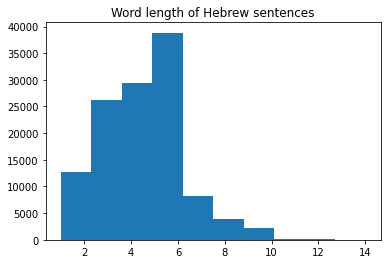

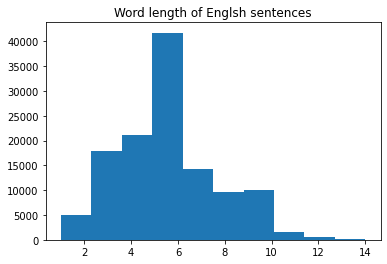

In [54]:
# study the data
eng_len = []
heb_len = []

for i in data[:,0]:                      # calculates word length of English sentences
      eng_len.append(len(i.split()))

for i in data[:,1]:                      # calculates word length of Hebrew sentences
      heb_len.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_len, 'heb':heb_len})

plt.title("Word length of Hebrew sentences")
plt.hist(length_df['heb'])        # Histogram of word length of Hebrew sentences
plt.show()
plt.title("Word length of Englsh sentences")
plt.hist(length_df['eng'])        # Histogram of word length of English sentences
plt.show()

In [55]:
print('Maximum length of German sentences - ', length_df['heb'].max())
print('Maximum length of English sentences - ', length_df['eng'].max())

Maximum length of German sentences -  14
Maximum length of English sentences -  14


In [56]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [57]:
# prepare English tokenizer
eng_tokenizer = tokenization(data[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
print('English Vocabulary Size: %d' % eng_vocab_size)

# prepare Hebrew tokenizer
heb_tokenizer = tokenization(data[:, 1])
heb_vocab_size = len(heb_tokenizer.word_index) + 1
print('Hebrew Vocabulary Size: %d' % heb_vocab_size)

English Vocabulary Size: 13304
Hebrew Vocabulary Size: 37531


In [58]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [61]:
# split data into training and testing set
train, test = train_test_split(data, test_size=0.002, random_state = 42)   #Test size is kept as 0.2% of complete data, since the dataset is huge and also testing cannot be done on lot of data due to memory shortage

# split training data into training and validation set
train, val = train_test_split(train, test_size=0.25, random_state = 42)   

In [63]:
#setting the max length of sentence. Later we'll pad every other shorter sentence with 0 (this includes both English and German sentences)
max_eng_length = 54   
max_heb_length = 65

# prepare training data
trainX = encode_sequences(heb_tokenizer, max_heb_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, max_eng_length, train[:, 0])

# prepare validation data
valX = encode_sequences(heb_tokenizer, max_heb_length, val[:, 1])
valY = encode_sequences(eng_tokenizer, max_eng_length, val[:, 0])

# prepare testing data
testX = encode_sequences(heb_tokenizer, max_heb_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, max_eng_length, test[:, 0])

In [64]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = tf.keras.models.Sequential()
      model.add(tf.keras.layers.Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(tf.keras.layers.LSTM(units))
      model.add(tf.keras.layers.RepeatVector(out_timesteps))
      model.add(tf.keras.layers.LSTM(units, return_sequences=True))
      model.add(tf.keras.layers.Dense(out_vocab, activation='softmax'))
      return model

In [65]:
# model compilation and summary
model = define_model(heb_vocab_size, eng_vocab_size, max_heb_length, max_eng_length, 128)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 65, 128)           4803968   
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 54, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 54, 128)           131584    
_________________________________________________________________
dense_3 (Dense)              (None, 54, 13304)         1716216   
Total params: 6,783,352
Trainable params: 6,783,352
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Set some other configurations for the model
adam = tf.keras.optimizers.Adam()
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy')

In [67]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience = 1)  # Stop training the model if 'val_loss' has stopped decreasing

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size = 64, validation_data = (valX, valY), callbacks=[early_stopping],
                    verbose=1)

model.save('/content/NMT_model.h5')

Epoch 1/30
1427/1427 [==============================] - 128s 87ms/step - loss: 0.8643 - val_loss: 0.6549
Epoch 2/30
1427/1427 [==============================] - 122s 85ms/step - loss: 0.6319 - val_loss: 0.6164
Epoch 3/30
1427/1427 [==============================] - 121s 85ms/step - loss: 0.5881 - val_loss: 0.5813
Epoch 4/30
1427/1427 [==============================] - 121s 85ms/step - loss: 0.5422 - val_loss: 0.5407
Epoch 5/30
1427/1427 [==============================] - 121s 85ms/step - loss: 0.4922 - val_loss: 0.5048
Epoch 6/30
1427/1427 [==============================] - 120s 84ms/step - loss: 0.4461 - val_loss: 0.4736
Epoch 7/30
1427/1427 [==============================] - 121s 85ms/step - loss: 0.4061 - val_loss: 0.4506
Epoch 8/30
1427/1427 [==============================] - 121s 85ms/step - loss: 0.3706 - val_loss: 0.4329
Epoch 9/30
1427/1427 [==============================] - 120s 84ms/step - loss: 0.3393 - val_loss: 0.4203
Epoch 10/30
1427/1427 [==============================] 

In [68]:
history_df = pd.DataFrame(history.history)
history_df.head()                  

,loss,val_loss
0,0.864329,0.654867
1,0.631921,0.616420
2,0.588079,0.581322
3,0.542235,0.540727
4,0.492153,0.504763


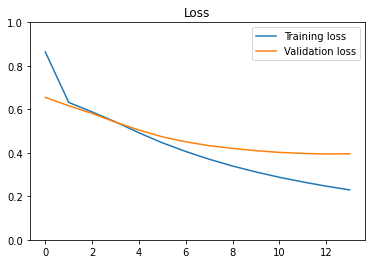

In [69]:
# plotting training and validation loss
plt.title('Loss')
plt.plot(history_df['loss'], label = 'Training loss')
plt.plot(history_df['val_loss'], label = 'Validation loss')
plt.ylim(0,1)
plt.legend()
plt.show()

In [70]:
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))   #make predictions

In [71]:
# function to convert predicted integers to corresponding words
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [72]:
# convert predicted integers to corresponding words
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [73]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [74]:
pred_df.to_csv('/content/predictions.csv')

In [75]:
# Download prediction file in local computer 
files.download('/content/predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
# Download saved model into local computer
files.download('/content/NMT_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>